# Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO

# Библиотеки: [Python, Tensorflow]

## Libs

In [1]:
import time
import os
import sys
import shutil
import skimage.io as io

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
COCO_ROOT = './data/'
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Sourse ds
http://images.cocodataset.org/zips/train2017.zip<br>
http://images.cocodataset.org/zips/val2017.zip<br>
http://images.cocodataset.org/annotations/annotations_trainval2017.zip<br>

https://github.com/cocodataset/cocoapi

## Select imgs

In [3]:
def select_files_COCO(sourse, sublist):
    start = time.time()
    
    ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', f'instances_{sublist}2017.json')
    coco = COCO(ann_file_fpath)
    cat_ids = coco.getCatIds(catNms=['person'])
    img_list = coco.getImgIds(catIds=cat_ids)
    
    fname_list = [coco.loadImgs(img)[0]['coco_url'].split('/')[-1] for img in img_list]
    
    path = f'./data/{sublist}2017/'
    if not os.path.exists(f'./data/{sublist}2017/'):
        os.mkdir(path)
    
    for file in os.listdir(sourse):
        if file in fname_list:
            shutil.copy(sourse + file, path + file)
            
    print(f'file count: {len(os.listdir(path))}, in {round(time.time() - start)} sec.')

In [4]:
%%time
# select_files_COCO(sourse='./val2017/', sublist='val')
# select_files_COCO(sourse='./train2017/', sublist='train')

Wall time: 0 ns


# Prep ds

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, epochs, batch_size, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [7]:
INP_SIZE = 256
BATCH_SIZE = 8
NUM_EPOCHS = 1

COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

loading annotations into memory...
Done (t=20.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


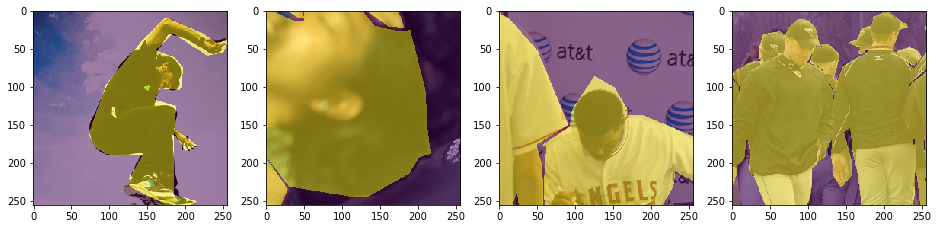

In [8]:
img, mask = next(iter(train_ds.take(1)))

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(img[i])
    plt.imshow(mask[i, ..., 0], alpha=0.5)

# Model

In [9]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        
        return out

In [10]:
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        
        self.conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        
        self.conv5 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        
        self.conv7 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        
        self.conv12 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        
        self.conv14 = layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        
        out_enc_mid = out
        
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)
        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        
        return out

In [11]:
loss_obj = tf.keras.losses.BinaryCrossentropy()
loss = tf.keras.metrics.Mean()

accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam()

model = ASPPNet()

## Checkpoint

In [12]:
checkpoint_path = "./checkpoints/trainASPP"

ckpt = tf.train.Checkpoint(
    model=model,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!')

Latest checkpoint restored!


# Training

In [13]:
test_img, test_mask = next(iter(val_ds))

In [14]:
%%time
for i, (train_img, train_mask) in enumerate(train_ds):

    # Forward
    with tf.GradientTape() as tape:
        train_mask_pred = model(train_img)
        train_loss_value = loss_obj(train_mask, train_mask_pred)

    # Backward
    gradients = tape.gradient(train_loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    loss(train_loss_value)
    accuracy(train_mask, train_mask_pred)
    
    if i % 200 == 0:
        test_mask_pred = model(test_img)
        test_loss_value = loss(test_mask, test_mask_pred)
        
        test_accuracy_value = accuracy(test_mask, test_mask_pred)
        train_accuracy_value = accuracy(train_mask, train_mask_pred)
        
        print(f'{i}\ttrain loss: {train_loss_value:.4f} | train accuracy: {train_accuracy_value:.4f} |',
              f'test loss: {test_loss_value:.4f} | test accuracy: {test_accuracy_value:.4f}')
        
        ckpt_manager.save()

0	train loss: 0.3165 | train accuracy: 0.7901 | test loss: 0.3763 | test accuracy: 0.8108
200	train loss: 0.3362 | train accuracy: 0.7764 | test loss: 0.3990 | test accuracy: 0.7763
400	train loss: 0.3343 | train accuracy: 0.7749 | test loss: 0.3839 | test accuracy: 0.7748
600	train loss: 0.3167 | train accuracy: 0.7777 | test loss: 0.3619 | test accuracy: 0.7776
800	train loss: 0.2698 | train accuracy: 0.7734 | test loss: 0.3643 | test accuracy: 0.7733
1000	train loss: 0.3553 | train accuracy: 0.7744 | test loss: 0.3507 | test accuracy: 0.7743
1200	train loss: 0.3810 | train accuracy: 0.7748 | test loss: 0.3552 | test accuracy: 0.7749
1400	train loss: 0.2534 | train accuracy: 0.7757 | test loss: 0.3563 | test accuracy: 0.7757
1600	train loss: 0.3518 | train accuracy: 0.7765 | test loss: 0.3592 | test accuracy: 0.7765
1800	train loss: 0.2742 | train accuracy: 0.7769 | test loss: 0.3616 | test accuracy: 0.7769
2000	train loss: 0.2475 | train accuracy: 0.7766 | test loss: 0.3676 | test a

## View train pred

In [15]:
PERCEPTION = 0.5

train_x, train_y = next(iter(train_ds))

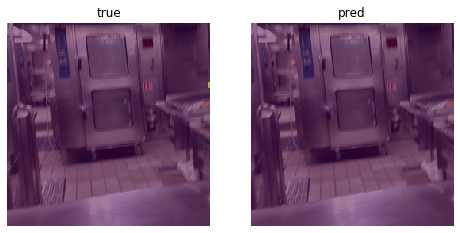

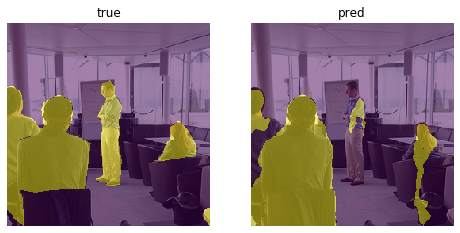

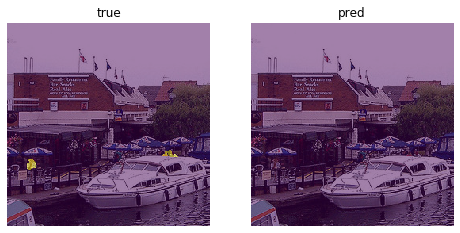

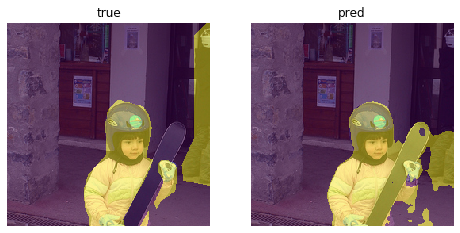

In [16]:
pred_prob = model(train_x[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.title('true')
    plt.imshow(train_x[i])
    plt.imshow(train_y[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('pred')
    plt.imshow(train_x[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')

## View val pred

In [17]:
val_x, val_y = next(iter(val_ds))

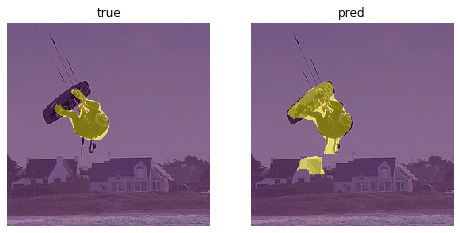

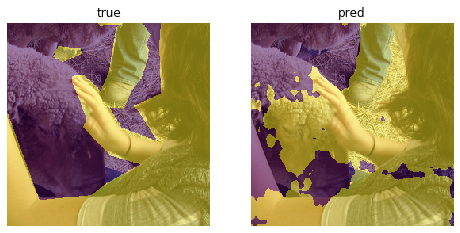

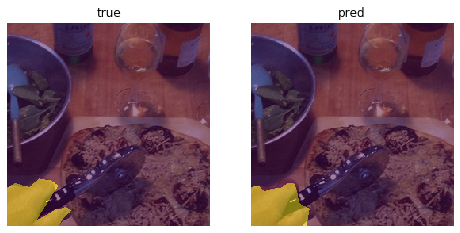

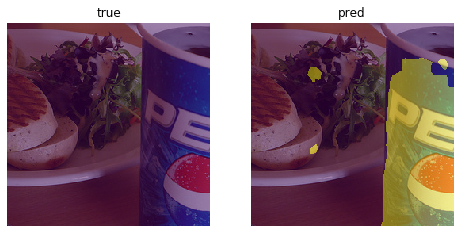

In [18]:
pred_prob = model(val_x[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.title('true')
    plt.imshow(val_x[i])
    plt.imshow(val_y[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('pred')
    plt.imshow(val_x[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')